In [1]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
img_info,object_tbl,bb_info,hit_info = load_info()

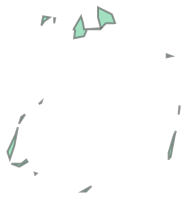

In [113]:
nonoverlap = (polygon.symmetric_difference(polygon2)).difference(polygon2)
nonoverlap==polygon.difference(polygon2)
nonoverlap

In [15]:
objid=14
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]

In [16]:
obj_x_locs = [process_raw_locs([x,y])[0] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
obj_y_locs = [process_raw_locs([x,y])[1] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [17]:
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [18]:
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))

In [147]:
def add_object_to_tiles(tiles,obj):
    if obj==[]:
        return
    if  obj.is_valid:
        if type(obj)==shapely.geometry.polygon.Polygon and obj.area>1e-10:
            tiles.append(obj)
        elif type(obj)==shapely.geometry.MultiPolygon or type(obj)==shapely.geometry.collection:
            for region in obj:
                if type(region)!=shapely.geometry.LineString and obj.area>1e-10:
                    tiles.append(region)        

In [148]:
tiles=[]

for i in tqdm(range(len(BB))):
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        for tj in tiles:
            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10: #eliminating spurious LineString-looking Polygons 
                    tiles.remove(tj)
                    add_object_to_tiles(tiles,xj)
                    diff_region = (tj.symmetric_difference(xj)).difference(xj)#.buffer(0)
                    add_object_to_tiles(tiles,diff_region)       
                    xj_lst.append(xj)
            except(shapely.errors.TopologicalError):
                print "error"
                xj_lst=xj_lst[:-1]
                pass
        try:
            leftovers = bi.difference(cascaded_union(xj_lst))
        except(shapely.errors.TopologicalError):
            leftovers = bi.difference(cascaded_union(xj_lst).buffer(1e-10))
        except(ValueError):
            #ERROR:shapely.geos:TopologyException: no outgoing dirEdge 
            leftovers=[]
        add_object_to_tiles(tiles,leftovers)

 15%|█▌        | 6/39 [00:04<00:24,  1.37it/s]ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 564.5 326.79999999999995 at 564.5 326.79999999999995
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (414.556 262.667, 413.5 259.5) and LINESTRING (413.5 259.5, 412 255) at 413.50000000000011 259.50000000000023


error
error

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 411.05000000000007 226.90000000000001 at 411.05000000000007 226.90000000000001


KeyboardInterrupt: 

In [149]:
print len(tiles)

585


In [152]:
np.min([t.area for t in tiles])

8.0779356694631609e-28

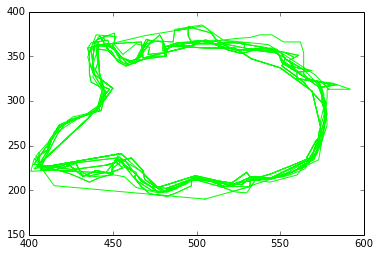

In [150]:
for t in tiles: 
#     plt.figure()
#     plt.title(tiles.index(t))
    if t.area>0:
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color="lime",reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString :
                    plot_coords(region,color="lime",reverse_xy=True)

### Testing for containment 

In [145]:
tiles[101].area

9.325873406851315e-15

# Production

In [12]:
img_info,object_tbl,bb_info,hit_info = load_info()
def add_object_to_tiles(tiles,obj):
    if type(obj)==shapely.geometry.polygon.Polygon:
        tiles.append(obj)
    elif type(obj)==shapely.geometry.MultiPolygon or type(obj)==shapely.geometry.collection:
        for region in obj:
            if type(obj)!=shapely.geometry.LineString:
                tiles.append(region)        
def BB2TileExact(objid):
    bb_objects = bb_info[bb_info["object_id"]==objid]
    bb_objects =  bb_objects[bb_objects.worker_id!=3]
    xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    BB = []
    for xyloc in xylocs:
        BB.append(Polygon(xyloc).buffer(0))
    tiles=[]
    for i in range(len(BB)):
        bi = BB[i]
        # base case, when i=0, only 2 polygon intersecting
        if i==0:
            tiles.append(bi)
        else: 
            xj_lst = []
            for tj in tiles:
                xj=tj.intersection(bi)
                if xj.area>1e-10: #eliminating spurious LineString-looking Polygons 
                    tiles.remove(tj)
                    add_object_to_tiles(tiles,xj)
                    diff_region = (tj.symmetric_difference(xj)).difference(xj) 
                    add_object_to_tiles(tiles,diff_region)       
                    xj_lst.append(xj)
            leftovers = bi.difference(cascaded_union(xj_lst))
            add_object_to_tiles(tiles,leftovers)
    return tiles
def visualizeTiles(tiles):
    plt.figure()
    for t in tiles: 
#     plt.title(tiles.index(t))
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color="lime",reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color="lime",reverse_xy=True)

In [14]:
tiles = BB2TileExact(14)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (439 327, 444.612 313.372) and LINESTRING (444.612 313.372, 444.612 313.372) at 444.61157024793391 313.37190082644616


TopologicalError: This operation could not be performed. Reason: unknown

  4%|▍         | 2/48 [00:01<00:23,  1.99it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (223.249 428.801, 194.378 416.216) and LINESTRING (205.754 421.175, 208.413 422.334) at 207.92785108757749 422.12239662791836


topological error:  1
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.6264 336.44, 73.5 331) and LINESTRING (73.5 331, 73.5 331) at 73.500000000000128 331.00000000000006


 2
bad

  8%|▊         | 4/48 [00:02<00:30,  1.45it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (107.778 370.118, 107.746 369.704) and LINESTRING (107.773 370.048, 107.746 369.704) at 107.76950710803544 370.00359240446073


 3
bad

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (454.824 168.118, 454.824 168.118) and LINESTRING (454.824 168.118, 454.824 168.118) at 454.82352941176475 168.11764705882368


 4
topological error: 

 12%|█▎        | 6/48 [00:04<00:29,  1.44it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (509.853 221.265, 509.853 221.265) and LINESTRING (509.853 221.265, 509.853 221.265) at 509.85294117647055 221.2647058823535


 5
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (401.947 128.789, 401.947 128.789) and LINESTRING (401.947 128.789, 401.947 128.789) at 401.9473684210526 128.78947368421044


 6
topological error: 

 17%|█▋        | 8/48 [00:05<00:27,  1.47it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (240.462 256.385, 240.462 256.385) and LINESTRING (240.462 256.385, 237 256) at 240.46153846153797 256.3846153846153


 7
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (380.688 238.396, 382.04 235.24) and LINESTRING (382.04 235.24, 381 237.667) at 381.09588815789471 237.44292763157895


 8
bad

 21%|██        | 10/48 [00:07<00:28,  1.33it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.421 269.643, 538.143 270.143) and LINESTRING (538.143 270.143, 538.543 266.343) at 538.14285714285711 270.14285714285722


 9
bad

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (424.057 340.343, 424.2 341.2) and LINESTRING (424.912 341.732, 424.057 340.343) at 424.05714285714288 340.34285714285721


 10
topological error: 

 25%|██▌       | 12/48 [00:09<00:27,  1.33it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (311.647 327.882, 316.667 336.667) and LINESTRING (316.667 336.667, 311.647 327.882) at 313.31340405014464 330.79845708775315


 11
topological error: 

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 220.46853146853144 390.23076923076923 at 220.46853146853144 390.23076923076923


 12
bad

 29%|██▉       | 14/48 [00:10<00:25,  1.32it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (439 327, 444.612 313.372) and LINESTRING (444.612 313.372, 444.612 313.372) at 444.61157024793391 313.37190082644616


 13
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.5 52.5, 397.5 52.5) and LINESTRING (397.5 52.5, 397.5 52.5) at 397.49999999999994 52.500000000000064


 14
bad

 33%|███▎      | 16/48 [00:11<00:23,  1.36it/s]ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 355.86552567237163 477.0146699266503 at 355.86552567237163 477.0146699266503


 15
bad

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (93.0081 177.878, 90.1401 183.102) and LINESTRING (96 179, 90.1401 183.102) at 90.140127388535035 183.10191082802547


 16
topological error: 

 38%|███▊      | 18/48 [00:12<00:20,  1.45it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (252.422 338.857, 250.972 338.934) and LINESTRING (250.972 338.934, 252.858 338.731) at 250.97205346294089 338.93438639125151


 17
topological error: 

ERROR:shapely.geos:TopologyException: side location conflict at 75.299999999999997 261.89999999999998


 18
topological error: 

 42%|████▏     | 20/48 [00:14<00:19,  1.42it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (490.476 234.904, 490.476 234.904) and LINESTRING (490.476 234.904, 490.476 234.904) at 490.47592738752957 234.90449881609996


 19
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (296 112, 295.688 102.798) and LINESTRING (295.794 105.921, 295.785 105.647) at 295.79047347145104 105.81896740780493


 20
topological error: 

 46%|████▌     | 22/48 [00:15<00:17,  1.46it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (396.296 132.535, 396.176 130.706) and LINESTRING (395.727 130.545, 396.296 132.535) at 396.2957746478873 132.5352112676054


 21
bad

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (517.177 124.58, 516.669 124.351) and LINESTRING (517.177 124.58, 516.669 124.351) at 516.78605977365737 124.40372689814578


 22
topological error: 

 50%|█████     | 24/48 [00:20<00:20,  1.19it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (347.228 257.485, 347.228 257.485) and LINESTRING (347.228 257.485, 347.228 257.485) at 347.22772277227716 257.48514851485123


 23
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (596.366 349.849, 596.366 349.849) and LINESTRING (596.366 349.849, 596.366 349.849) at 596.36559139785084 349.84946236559324


 24
bad

 54%|█████▍    | 26/48 [00:21<00:18,  1.20it/s]ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 89 285 at 89 285


 25
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50.5517 485.517, 51.89 484.346) and LINESTRING (50.5517 485.517, 50.5517 485.517) at 50.551724137931096 485.51724137931024


 26
bad

 58%|█████▊    | 28/48 [00:23<00:16,  1.19it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (352.099 63.0514, 352.634 62.554) and LINESTRING (350.84 64.22, 362.353 53.5294) at 352.13049407876792 63.021684069715484


 27
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (494 187, 487.593 176.475) and LINESTRING (489 180, 489.229 179.161) at 489.22869955156949 179.16143497757847


 28
topological error: 

 62%|██████▎   | 30/48 [00:25<00:15,  1.17it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60 114, 42 118) and LINESTRING (55.236 115.059, 57.25 114.611) at 55.236048780487806 115.05865582655827


 29
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (26.3705 337.113, 27.4667 355.2) and LINESTRING (27.2593 351.778, 27.2593 351.778) at 27.25925925925926 351.77777777777777


 30
bad

 67%|██████▋   | 32/48 [00:26<00:13,  1.21it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (362 380, 371.994 357.706) and LINESTRING (374.846 347.513, 371.372 359.093) at 371.37209302325584 359.09302325581388


 31
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (418.587 277.806, 418.357 274.357) and LINESTRING (418.357 274.357, 418.357 274.357) at 418.35714285711782 274.35714285746798


 32
topological error: 

 71%|███████   | 34/48 [00:27<00:11,  1.26it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (64 151, 109.319 249.191) and LINESTRING (65.2397 153.686, 109.319 249.191) at 75.329787234042357 175.54787234042507


 33
topological error: 

ERROR:shapely.geos:TopologyException: side location conflict at 261 75


 34
topological error: 

 75%|███████▌  | 36/48 [00:29<00:09,  1.20it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (277.5 591.472, 280.038 597.253) and LINESTRING (280.528 597.046, 280.038 597.253) at 280.03797461234188 597.25316439477842


 35
bad

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (557.836 234.131, 556 230) and LINESTRING (557.836 234.131, 556.167 230.375) at 556.94840935730429 232.1339210539347


 36
topological error: 

 79%|███████▉  | 38/48 [00:32<00:08,  1.16it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (493.133 198.773, 493.714 254.571) and LINESTRING (493.714 254.571, 492 222) at 493.71428571428555 254.57142857141503


 37
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (78.234 360.915, 78.234 360.915) and LINESTRING (78.234 360.915, 78.234 360.915) at 78.234042553191443 360.91489361702122


 38
topological error: 

 83%|████████▎ | 40/48 [00:33<00:06,  1.18it/s]ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 169.03864205575152 157.75186312638732 at 169.03864205575152 157.75186312638732


 39
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (394.136 535.682, 394.136 535.682) and LINESTRING (394.136 535.682, 394.136 535.682) at 394.13636363636459 535.68181818181824


 40
topological error: 

 88%|████████▊ | 42/48 [00:36<00:05,  1.16it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (170 491, 175 488.727) and LINESTRING (175 488.727, 175 488.727) at 174.99999999999983 488.72727272727275


 41
bad

ERROR:shapely.geos:TopologyException: side location conflict at 184 299
 92%|█████████▏| 44/48 [00:36<00:03,  1.20it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (272 299, 261.523 298.345) and LINESTRING (262.027 298.441, 261.871 298.367) at 261.87050359712237 298.36690647482015


 42
topological error:  43
topological error: 

ERROR:shapely.geos:TopologyException: side location conflict at 102 142


 44
topological error: 

 96%|█████████▌| 46/48 [00:38<00:01,  1.21it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (108.545 425.663, 110 424) and LINESTRING (108.86 425.302, 109.826 421.826) at 108.86046511627907 425.30232558139534


 45
topological error: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (207.545 171.182, 208.816 155.296) and LINESTRING (208.861 154.737, 208.432 160.099) at 208.80523055348155 155.43461808148064


 46
bad

 47


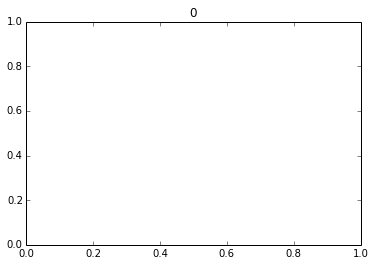

In [13]:
for objid in tqdm(range(48)):
    try: 
        tiles = BB2TileExact(objid) 
        visualizeTiles(tiles)
        plt.title(objid)
    except(shapely.errors.TopologicalError):
        #TopologicalError: The operation 'GEOSDifference_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x10ae127d0>
        print "topological error: " , objid
        pass
    except:
        print "bad",objid
        pass

In [179]:
tiles[0].area

1.2523315717771766e-13